## Hugging Face Dataset + DataLoader Demo

In our previous tutorials, we performed some inferencing on a model using a single input _only_. In general, however, you can do so on a batch of input. To automatically evaluate a model on multiple data requires the use of a dataloader. In this demo, we will explore very briefly how dataloaders are being used.

To start, please install the datasets library via pip: `pip install datasets`

### Loading a Dataset from the Hugging Face library

First, we load the model we will be using for this demo. Let us use the same model from our previous tutorials, which is the DEIT Tiny and Distilled Model from Facebook research group.

In [1]:
from transformers import DeiTForImageClassificationWithTeacher

model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-tiny-distilled-patch16-224')

Other than models, Hugging Face also contains plenty of common datasets in their library. In this section, we will try to evaluate our loaded model on a Hugging Face dataset.

For more information on available datasets in Hugging Face, please [visit this link](https://huggingface.co/datasets).

In [2]:
import datasets

For this example, let us use the images from the cifar10 dataset. Specifically, we load in the test split _only_ from cifar10.

In [3]:
dataset = datasets.load_dataset('cifar10', split='test')

Reusing dataset cifar10 (/home/izza/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


The basic idea of what a dataloader does is to load your inputs and feed them to your neural model. So, in a sense, you can actually brute force this process by manually retrieving your data one by one from a folder and feeding them to your model for either training or evaluation.

However, _**THIS IS NOT RECOMMENDED**_ as it is very, _very_ inefficient. Neural models have the capacity to accept a _batch_ of inputs, where each batch contains _N_ inputs (this is the same _N_ we referenced earlier in our [numpy demo](https://github.com/izzajalandoni/Deep-Learning-Helper/blob/main/Lecture0-Toolkits/numpy_demo.ipynb)). Hence, we use dataloader as a way to load our data, _organize them_, and extract them _by batch_ before feeding said batch to a neural model.

This will be discussed in more detail as we go through the `dataset` topic.

#### Inspecting the Format of our Dataset

It is advisable to always inspect the format of your data whenever you're loading them from libraries, such as Hugging Face, or other sources. This is so that you will know if said data requires further processing before inputing them to your model.

In [4]:
dataset

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [5]:
dataset[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FF360339790>,
 'label': 3}

In [6]:
import numpy as np
np.unique(dataset[:]['label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

From here, we can see that our dataset contains two things: an RGB PIL image `'img'` of size 32x32, and its corresponding `'label'`, where label ranges from [0:9]. You can verify these data infos from the Hugging Face page as well. For cifar10, [please visit this link](https://huggingface.co/datasets/cifar10).

In [7]:
dataset = dataset.rename_column('img', 'pixel_values')
dataset = dataset.remove_columns(['label'])

In [8]:
dataset[0]

{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FF3602FA670>}

Given our image is a PIL image, we need to convert this to tensor. We can do this by combining the torchvision transforms we learned previously alongside the `set_transform()` function of Hugging Face.

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

def transform_input(data):
    data['pixel_values'] = [transform(image.convert('RGB')) for image in data['pixel_values']]
    return data

In [10]:
dataset.set_transform(transform=transform_input)

In [11]:
dataset[0]

{'pixel_values': tensor([[[0.6196, 0.6196, 0.6196,  ..., 0.4549, 0.4549, 0.4549],
          [0.6196, 0.6196, 0.6196,  ..., 0.4549, 0.4549, 0.4549],
          [0.6196, 0.6196, 0.6196,  ..., 0.4549, 0.4549, 0.4549],
          ...,
          [0.2118, 0.2118, 0.2118,  ..., 0.0824, 0.0824, 0.0824],
          [0.2118, 0.2118, 0.2118,  ..., 0.0824, 0.0824, 0.0824],
          [0.2118, 0.2118, 0.2118,  ..., 0.0824, 0.0824, 0.0824]],
 
         [[0.4392, 0.4392, 0.4392,  ..., 0.3333, 0.3333, 0.3333],
          [0.4392, 0.4392, 0.4392,  ..., 0.3333, 0.3333, 0.3333],
          [0.4392, 0.4392, 0.4392,  ..., 0.3333, 0.3333, 0.3333],
          ...,
          [0.4196, 0.4196, 0.4196,  ..., 0.2627, 0.2627, 0.2627],
          [0.4196, 0.4196, 0.4196,  ..., 0.2627, 0.2627, 0.2627],
          [0.4196, 0.4196, 0.4196,  ..., 0.2627, 0.2627, 0.2627]],
 
         [[0.1922, 0.1922, 0.1922,  ..., 0.1294, 0.1294, 0.1294],
          [0.1922, 0.1922, 0.1922,  ..., 0.1294, 0.1294, 0.1294],
          [0.1922, 0.192

#### Using torch DataLoader

Users actually have the option to also design their own dataloader function (or class) however they see fit. And you can put your own data preprocessing steps within that same dataloader function. For this demo, however, we will simply be using the `dataloader` function from torch.

In [12]:
import torch

testloader = torch.utils.data.DataLoader(dataset, batch_size=4)

Since we specified a batch size of 4, ie N=4, if we iterate on this batch and inspect our loader by calling `next(iter(testloader))`, it should give us N=4 `pixel_values` of type `tensor`.

In [13]:
batch = next(iter(testloader))
print(batch['pixel_values'].shape)

torch.Size([4, 3, 224, 224])


In this next step, we simply create a function  that will display our output.

In [14]:
import matplotlib.pyplot as plt

def display_outputs(data, model, logits):
    num_outputs = logits.shape[0]
    
    for i in range(num_outputs):
        pred_label = logits[i].argmax(-1).item()
        pred_class = model.config.id2label[pred_label]
        image = data['pixel_values'][i].permute((1,2,0))
        plt.imshow(image)
        plt.show()
        print("label: {}, class: {}".format(pred_label, pred_class))
    

Below is the same process we did in our previous [Hugging Face demo](https://github.com/izzajalandoni/Deep-Learning-Helper/blob/main/Lecture0-Toolkits/huggingface_demo.ipynb). Please see under the `Hugging Face on Image Classification` section. The difference is we placed it inside the loop, and set the batch size to N=4. Again, what this does is our model can now iterate over the entire dataset, and processes N=4 inputs per iteration.

Note: `tqdm` is a library that simply keeps track of our progress.

0it [00:00, ?it/s]

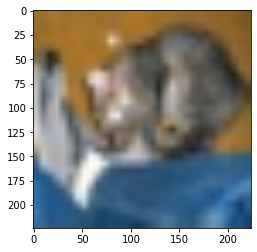

label: 335, class: fox squirrel, eastern fox squirrel, Sciurus niger


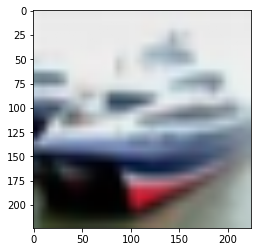

label: 814, class: speedboat


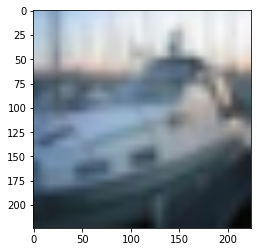

label: 408, class: amphibian, amphibious vehicle


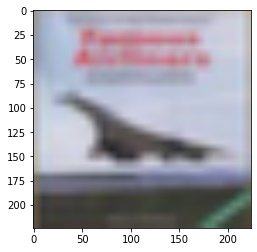

0it [00:00, ?it/s]

label: 473, class: can opener, tin opener
Done!


In [15]:
from tqdm import tqdm

for idx, data in tqdm(enumerate(testloader)):
    output = model(**data)
    logits = output.logits
    
    # If you want the model to go over the entire dataset, you may do so by removing 'break'
    # However, I advise that you please comment out display_outputs() as well.    
    display_outputs(data, model, logits)
    break
    
print("Done!")

Inaccurate prediction is probably caused by the low resolution of our image (result of resizing an originally 32x32 image to 224x224). More information about Hugging Face datasets [here](https://huggingface.co/docs/datasets/index).